# Dependencias

In [1]:
import os
import time
import pickle

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks, optimizers
from keras.utils.vis_utils import plot_model

from lib.data_normalizer import draw_image_with_boxes

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

IMAGE_SHAPE = (227,227)

2022-11-28 17:51:45.707069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 17:51:47.475208: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2022-11-28 17:51:47.475284: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2022-11-28 17:51:47.482241: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2022-11-28 17:51:47.754122: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


# Modelo de identificación de placas

In [4]:
res_net_50 = tf.keras.applications.ResNet50( input_tensor = layers.Input(
    shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3)),
    include_top=False,
    weights='imagenet')

# Let's create a function that will construct our model
def create_model(no_of_classes):

    # Allow the model to be trained
    res_net_50.trainable = True

    # Start by taking the output feature maps from ResNet50
    base_model_output = res_net_50.output

    # Flatten the output feature maps to a 1D vector with GlobalAveragePooling2D, more effective than Flatten
    # due to a reduction in the number of parameters and better control of overfitting.
    flattened_output = layers.GlobalAveragePooling2D()(base_model_output)



    # Create Our Localization Head, final layer contains 4 nodes for x1,y1,x2,y2
    # Respectively.
    box_output = layers.Dense(256, activation="relu")(flattened_output)
    box_output = layers.Dense(128, activation="relu")(box_output)
    box_output = layers.Dropout(0.2)(box_output)
    box_output = layers.Dense(64, activation="relu")(box_output)
    box_output = layers.Dropout(0.2)(box_output)
    box_output = layers.Dense(32, activation="relu")(box_output)
    box_predictions = layers.Dense(4, activation="sigmoid", name= "box_output")(box_output)

    # Now combine the model with the localization head
    model = models.Model(inputs=res_net_50.input, outputs= box_predictions)

    return model

# Create the model for 1 class
model = create_model(1);
plot_model(model, to_file="models/resNet50_box_model_plot.png", show_shapes=True,
           show_layer_names=True)



# Callback function to stop training when  validation data  loss does not decrease by 0.001 in 40 epochs
stop = callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40,
                    restore_best_weights = True)

# Change the learning rate according to number of epochs to boost learning
reduce_lr = callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002,
                              patience = 30, min_lr = 1e-7, verbose = 1)


# Compile the model
model.compile(optimizer = optimizers.SGD(learning_rate = 1e-2, momentum = 0.9),
              loss = "mean_squared_error", metrics = "mse")

# Carga de Datos

In [3]:
# Load csv
plates_data = pd.read_csv("./normalized_data/unique_plates.csv")

# Take two mutual exclusive samples of the data for training and validation
train_plates = plates_data.sample(frac=0.8,random_state=200)
test_plates = plates_data.drop(train_plates.index)

# Create the arrays with the inputs and outputs for testing and training data
# training vectors
train_plates_data_in = np.ndarray(shape=(len(train_plates), IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), dtype=np.uint8)
train_plates_data_out_box = np.array([train_plates['xmin'],
                                      train_plates['ymin'],
                                      train_plates['xmax'],
                                      train_plates['ymax']]).T
train_plates_data_out_tag = np.array([train_plates['tag'],]).T
# testing vectors
test_plates_data_in = np.ndarray(shape=(len(train_plates), IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), dtype=np.uint8)
test_plates_data_out_box = np.array([test_plates['xmin'],
                                     test_plates['ymin'],
                                     test_plates['xmax'],
                                     test_plates['ymax']]).T
test_plates_data_out_tag = np.array([test_plates['tag'],]).T



# Load train images into RAM from paths in csv
for i, path in enumerate(train_plates['img_path']):
    raw_image = cv2.imread(path, cv2.IMREAD_COLOR)
    train_plates_data_in[i,:,:,:] = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)  # Reorganize channels from BGR -> RGB

# Normalize inputs
for i in range(len(train_plates_data_out_box)):
    train_plates_data_out_tag[i][0] = train_plates_data_out_tag[i][0] / 100             # tag
    train_plates_data_out_box[i][0] = train_plates_data_out_box[i][0] / IMAGE_SHAPE[0]  # xmin
    train_plates_data_out_box[i][1] = train_plates_data_out_box[i][1] / IMAGE_SHAPE[1]  # ymin
    train_plates_data_out_box[i][2] = train_plates_data_out_box[i][2] / IMAGE_SHAPE[0]  # xmax
    train_plates_data_out_box[i][3] = train_plates_data_out_box[i][3] / IMAGE_SHAPE[1]  # ymax


# Test de datos

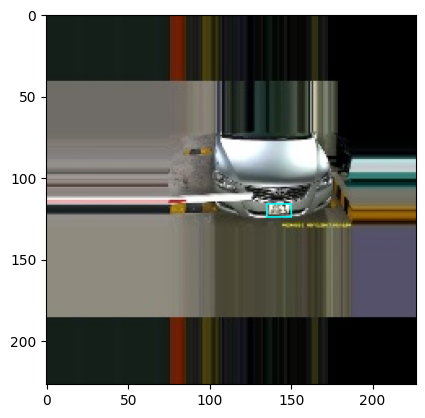

In [8]:
i = np.random.randint(0, len(train_plates_data_in))
# Scale predicted data
predicted_data = [[0.0,0.0,0.0,0.0,0.0]]
predicted_data[0][1] = train_plates_data_out_box[i][0] * IMAGE_SHAPE[0]  # xmin
predicted_data[0][2] = train_plates_data_out_box[i][1] * IMAGE_SHAPE[1]  # ymin
predicted_data[0][3] = train_plates_data_out_box[i][2] * IMAGE_SHAPE[0]  # xmax
predicted_data[0][4] = train_plates_data_out_box[i][3] * IMAGE_SHAPE[1]  # ymax

draw_image_with_boxes(train_plates_data_in[i], predicted_data, border = 1)


# Entrenamiento

In [9]:
# Train the Model
history = model.fit(x = train_plates_data_in,
                    y = train_plates_data_out_box,
                    validation_split=0.2,
                    batch_size = 32, epochs = 200,
                    callbacks=[reduce_lr, stop])
# Save model
model.save('models/ResNet50Box_01.h5')
# Save training history
with open("./models/ResNet50Box_history.pickle", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

2022-11-27 03:48:52.787753: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 887020206 exceeds 10% of free system memory.
2022-11-27 03:48:56.377524: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 887020206 exceeds 10% of free system memory.


Epoch 1/200


2022-11-27 03:49:01.045110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-27 03:49:01.657072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-27 03:49:01.657132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13970 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


180/180 [==============================] - ETA: 0s - loss: 0.0146 - mse: 0.0146

2022-11-27 03:49:53.448268: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 221832345 exceeds 10% of free system memory.
2022-11-27 03:49:53.641055: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 221832345 exceeds 10% of free system memory.
2022-11-27 03:49:54.161180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-27 03:49:54.352630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-27 03:49:54.352679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13970 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


180/180 [==============================] - 61s 316ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0090 - val_mse: 0.0090 - lr: 0.0100
Epoch 2/200
180/180 [==============================] - 55s 305ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0074 - val_mse: 0.0074 - lr: 0.0100
Epoch 3/200
180/180 [==============================] - 63s 348ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0066 - val_mse: 0.0066 - lr: 0.0100
Epoch 4/200
180/180 [==============================] - 55s 306ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0061 - val_mse: 0.0061 - lr: 0.0100
Epoch 5/200
180/180 [==============================] - 55s 307ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0056 - val_mse: 0.0056 - lr: 0.0100
Epoch 6/200
180/180 [==============================] - 55s 305ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0052 - val_mse: 0.0052 - lr: 0.0100
Epoch 7/200
180/180 [==============================] - 55s 306ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0049 

# Métricas de entrenamiento

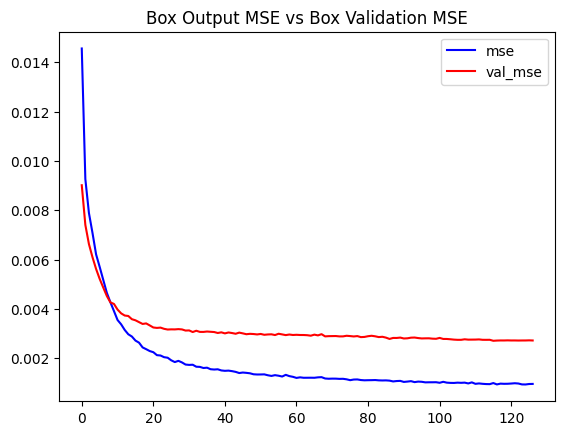

In [35]:
with open("./models/ResNet50Box_history.pickle", "rb") as file_pi:
    history = pickle.load(file_pi)

def plot(var1, var2, plot_name):
    # Get the loss metrics from the trained model
    c1 = history[var1]
    c2 = history[var2]

    epochs = range(len(c1))

    # Plot the metrics
    plt.plot(epochs, c1, 'b', label=var1)
    plt.plot(epochs, c2, 'r', label=var2)
    plt.title(str(plot_name))
    plt.legend()

# plot('box_output_mse','val_box_output_mse','Box Output MSE vs Box Validation MSE')
# plot('box_output_loss','val_box_output_loss','Box Output Loss vs Box Validation Loss')
# These are the most important metrics in telling us how our model is doing

plot( 'mse', 'val_mse', 'Box Output MSE vs Box Validation MSE')

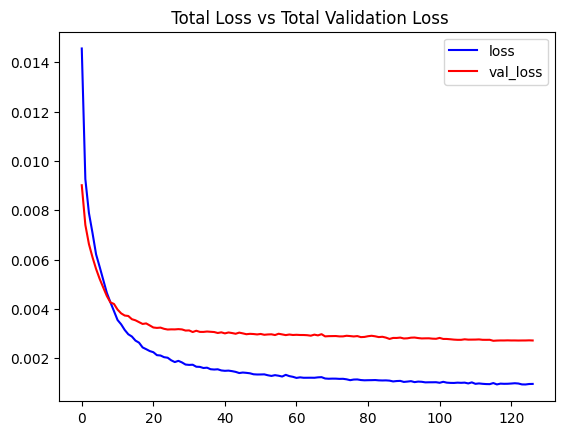

In [36]:
plot('loss','val_loss',' Total Loss vs Total Validation Loss')

# Cargar datos de prueba

In [4]:
# Load train images into RAM from paths in csv
for i, path in enumerate(train_plates['img_path']):
    raw_image = cv2.imread(path, cv2.IMREAD_COLOR)
    train_plates_data_in[i,:,:,:] = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)  # Reorganize channels from BGR -> RGB

# Normalize inputs
for i in range(len(train_plates_data_out_box)):
    train_plates_data_out_tag[i][0] = train_plates_data_out_tag[i][0] / 100             # tag
    train_plates_data_out_box[i][0] = train_plates_data_out_box[i][0] / IMAGE_SHAPE[0]  # xmin
    train_plates_data_out_box[i][1] = train_plates_data_out_box[i][1] / IMAGE_SHAPE[1]  # ymin
    train_plates_data_out_box[i][2] = train_plates_data_out_box[i][2] / IMAGE_SHAPE[0]  # xmax
    train_plates_data_out_box[i][3] = train_plates_data_out_box[i][3] / IMAGE_SHAPE[1]  # ymax

## Usar modelo

1/1 [==============================] - 0s 462ms/step


2022-11-28 18:04:39.601052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Salida: [[0.361 0.554 0.619 0.63 ]]


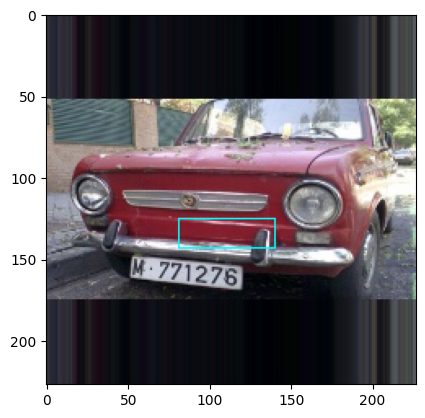

In [17]:


def resize_image(image: np.ndarray, desired_resolution: tuple) -> np.ndarray:
    """
    Resize an image to a given size
    :param image: Image to resize
    :param size: Size to resize to
    :return: Resized image
    """

    # return cv2.resize(image, desired_resolution, interpolation=cv2.INTER_AREA)
    return image


model = models.load_model("./models/ResNet50Box_01.h5")


test_image = np.ndarray(shape=(1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), dtype=np.uint8)
test_image[0] = train_plates_data_in[np.random.randint(0, len(train_plates_data_in))]


predicted_data = model.predict(test_image)
print("Salida: " + str(predicted_data))


# Scale predicted data
predicted_data[0][0] = predicted_data[0][0] * IMAGE_SHAPE[0]  # xmin
predicted_data[0][1] = predicted_data[0][1] * IMAGE_SHAPE[1]  # ymin
predicted_data[0][2] = predicted_data[0][2] * IMAGE_SHAPE[0]  # xmax
predicted_data[0][3] = predicted_data[0][3] * IMAGE_SHAPE[1]  # ymax

printable_data = [[0, predicted_data[0][0], predicted_data[0][1], predicted_data[0][2], predicted_data[0][3]]]

# predicted_data[0][1] = 10  # xmin
# predicted_data[0][2] = 10  # ymin
# predicted_data[0][3] = 100  # xmax
# predicted_data[0][4] = 100  # ymax

draw_image_with_boxes(test_image[0], printable_data, border = 1)